<a href="https://colab.research.google.com/github/luixmartins/time-series-forecasting/blob/main/m5_competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.5 MB/s eta 0:00:00


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import plotly.express as px
import plotly.graph_objects as go

from pmdarima import auto_arima
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from prophet import Prophet

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dropout, LSTM, Dense, Bidirectional, Activation
from tensorflow import keras

import warnings
warnings.filterwarnings("ignore")

# PT 1 - Data Analysis

In [ ]:
# loading data

calendar = pd.read_csv('/content/drive/MyDrive/calendar.csv')
sell_prices = pd.read_csv('/content/drive/MyDrive/sell_prices.csv')
sales_train_validation = pd.read_csv('/content/drive/MyDrive/sales_train_validation.csv')

In [ ]:
# reduce memory usage

def downcast_dtypes(dataframe):
  float_cols = [column for column in dataframe if dataframe[column].dtype == 'float64']
  int_cols = [column for column in dataframe if dataframe[column].dtype in ['int64', 'int32']]

  dataframe[float_cols] = dataframe[float_cols].astype(np.float32)
  dataframe[int_cols] = dataframe[int_cols].astype(np.int16)

  return dataframe

sell_prices = downcast_dtypes(sell_prices)
sales_train_validation = downcast_dtypes(sales_train_validation)

In [ ]:
df_melt = pd.melt(sales_train_validation,
                  id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
                  var_name='day', value_name='demand')

df_melt.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [ ]:
df_melt['store_id'].unique()

array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3'], dtype=object)

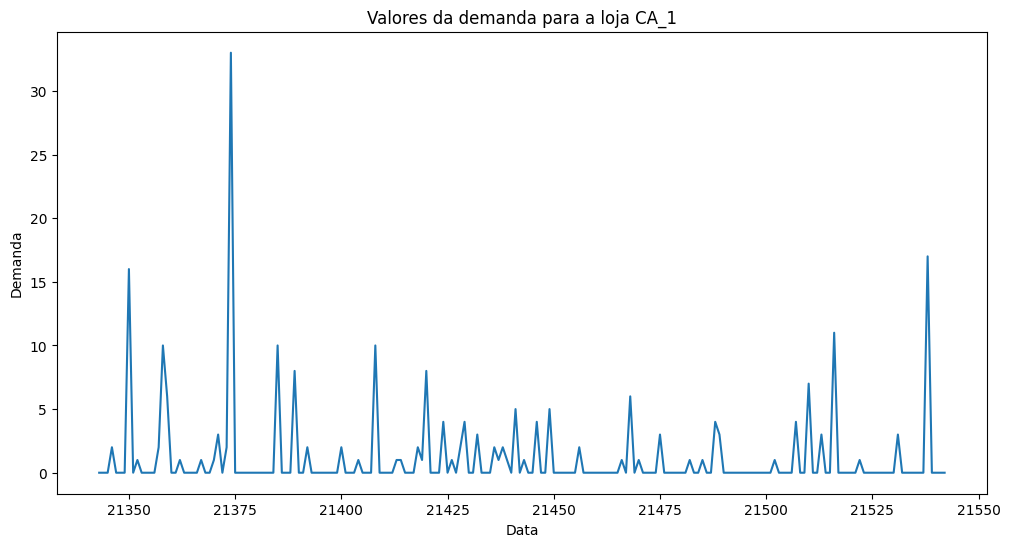

In [ ]:
import matplotlib.pyplot as plt

# Filtrar o dataframe
df_filtered = df_melt[df_melt['store_id'] == 'WI_1']

# Plotar os valores
plt.figure(figsize=(12,6))
plt.plot(df_filtered['demand'][:200])
plt.title('Valores da demanda para a loja CA_1')
plt.xlabel('Data')
plt.ylabel('Demanda')
plt.show()

In [ ]:
calendar['event_name_1'].unique()

array([nan, 'SuperBowl', 'ValentinesDay', 'PresidentsDay', 'LentStart',
       'LentWeek2', 'StPatricksDay', 'Purim End', 'OrthodoxEaster',
       'Pesach End', 'Cinco De Mayo', "Mother's day", 'MemorialDay',
       'NBAFinalsStart', 'NBAFinalsEnd', "Father's day",
       'IndependenceDay', 'Ramadan starts', 'Eid al-Fitr', 'LaborDay',
       'ColumbusDay', 'Halloween', 'EidAlAdha', 'VeteransDay',
       'Thanksgiving', 'Christmas', 'Chanukah End', 'NewYear',
       'OrthodoxChristmas', 'MartinLutherKingDay', 'Easter'], dtype=object)

In [ ]:
"""
  - Use one store for prediction - (TX_3)
  - Merge all datasets
"""

sales = df_melt[df_melt.store_id == 'WI_1']

wi_1 = pd.merge(sales, calendar, left_on='day', right_on='d', how='left')
wi_1 = pd.merge(wi_1, sell_prices, left_on=['store_id', 'item_id', 'wm_yr_wk'],
                right_on=['store_id', 'item_id', 'wm_yr_wk'], how='left')

wi_1['day_int'] = wi_1.day.apply(lambda x: int(x.split('_')[-1]))

wi_1.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,date,wm_yr_wk,...,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,day_int
0,HOBBIES_1_001_WI_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,WI_1,WI,d_1,0,2011-01-29,11101,...,d_1,NaN,NaN,NaN,NaN,0,0,0,NaN,1
1,HOBBIES_1_002_WI_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,WI_1,WI,d_1,0,2011-01-29,11101,...,d_1,NaN,NaN,NaN,NaN,0,0,0,NaN,1
2,HOBBIES_1_003_WI_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,WI_1,WI,d_1,0,2011-01-29,11101,...,d_1,NaN,NaN,NaN,NaN,0,0,0,NaN,1
3,HOBBIES_1_004_WI_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,WI_1,WI,d_1,2,2011-01-29,11101,...,d_1,NaN,NaN,NaN,NaN,0,0,0,4.34,1
4,HOBBIES_1_005_WI_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,WI_1,WI,d_1,0,2011-01-29,11101,...,d_1,NaN,NaN,NaN,NaN,0,0,0,NaN,1


In [ ]:
wi_1.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'day',
       'demand', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'day_int'],
      dtype='object')

In [ ]:
# select columns and fill nan values

wi = wi_1[['date', 'item_id', 'day_int', 'demand','weekday', 'event_type_1',   'sell_price']]

wi['event_type_1'] = wi['event_type_1'].fillna('not event')
wi = wi.fillna(0)

wi.head()

,date,item_id,day_int,demand,weekday,event_type_1,sell_price
0,2011-01-29,HOBBIES_1_001,1,0,Saturday,not event,0.00
1,2011-01-29,HOBBIES_1_002,1,0,Saturday,not event,0.00
2,2011-01-29,HOBBIES_1_003,1,0,Saturday,not event,0.00
3,2011-01-29,HOBBIES_1_004,1,2,Saturday,not event,4.34
4,2011-01-29,HOBBIES_1_005,1,0,Saturday,not event,0.00


In [ ]:
# Filtrar o dataframe para linhas onde 'demand' é maior que 0
df_filtered = wi[wi['demand'] > 0]

# Agrupar por 'item_id' e contar o número de linhas
item_counts = df_filtered.groupby('item_id').size()

# Encontrar o item com a contagem máxima
max_item = item_counts.idxmax()

print(f"O item com mais valores acima de 0 na coluna 'demand' é: {max_item}")

O item com mais valores acima de 0 na coluna 'demand' é: FOODS_3_226


In [ ]:
"""
  - Select one item for prediction
  - Extract features from date, sales and demand
"""

def date_features(df):
  df["date"] = pd.to_datetime(df["date"])
  df["day"] = df.date.dt.day
  df["month"] = df.date.dt.month
  df["week_day"] = df.date.dt.weekday

  #df.drop(columns="date", inplace=True)

  return df

def encode_features(df):
  df = pd.get_dummies(df, columns=['weekday', 'event_type_1'])

  return df

def sales_features(df):
  df.sell_price.fillna(0, inplace=True)

  return df

def demand_features(df):
  df["lag_t30"] = df["demand"].transform(lambda x: x.shift(30))
  df["rolling_mean_t7"] = df["demand"].transform(lambda x:x.shift(30).rolling(7).mean())
  df['rolling_mean_t30'] = df['demand'].transform(lambda x: x.shift(30).rolling(30).mean())
  df['rolling_mean_t60'] = df['demand'].transform(lambda x: x.shift(30).rolling(60).mean())
  df['rolling_mean_t90'] = df['demand'].transform(lambda x: x.shift(30).rolling(90).mean())
  df['rolling_mean_t180'] = df['demand'].transform(lambda x: x.shift(30).rolling(180).mean())
  df['rolling_std_t7'] = df['demand'].transform(lambda x: x.shift(30).rolling(7).std())
  df['rolling_std_t30'] = df['demand'].transform(lambda x: x.shift(30).rolling(30).std())

  df.fillna(0, inplace=True)

  return df

item = wi[wi.item_id == 'FOODS_3_226'][['date', 'sell_price', 'weekday', 'event_type_1', 'demand']]

item_df = date_features(item)
item_df = encode_features(item_df)
item_df = sales_features(item_df)
item_df = demand_features(item_df)

item_df.index = item_df['date']
item_df.drop(columns='date', inplace=True)

item_df.head()

item_df.to_csv('/content/drive/MyDrive/datasets/m5_competition_wi.csv')

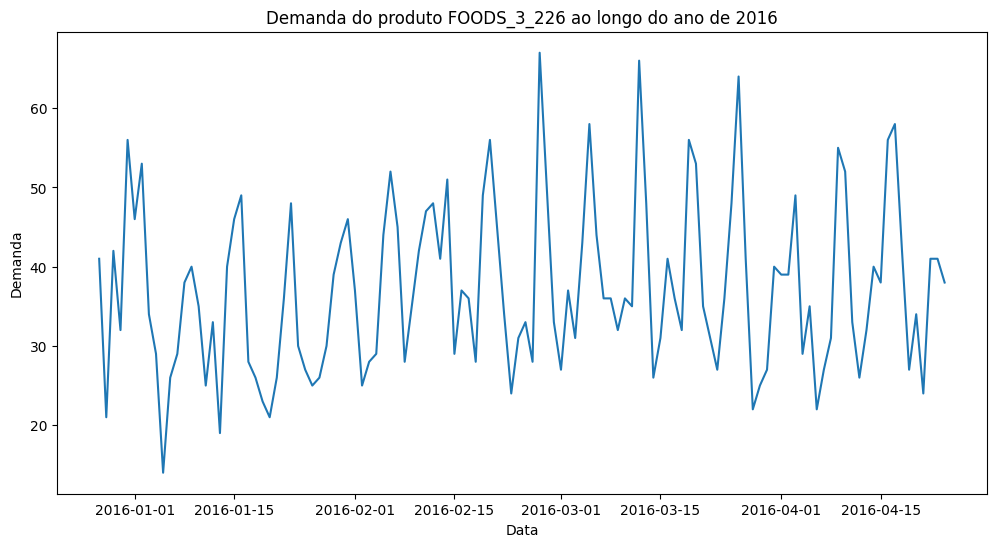

In [ ]:
import matplotlib.pyplot as plt

# Plotar a coluna 'demand'
plt.figure(figsize=(12,6))
plt.plot(item_df['demand'][len(item_df) - 120:])
plt.title('Demanda do produto FOODS_3_226 ao longo do ano de 2016')
plt.xlabel('Data')
plt.ylabel('Demanda')
plt.show()

# PT 2 - Predictive Models


In [3]:
df = pd.read_csv('/content/drive/MyDrive/datasets/m5_competition_wi.csv')

df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
df.index = df['date']

df.drop(columns=['date', 'week_day'], inplace=True)

df = df.loc['2012':]

## Moving average

In [4]:
window_size = 7

train_mva = df.loc[:'2015-12-31']
test_mva = df.loc['2016-01-01':'2016-04-24']

train_mva['moving_avg'] = train_mva['demand'].rolling(window=window_size).mean()

test_mva['prediction_mva'] = train_mva['demand'].iloc[-window_size:].mean()

rmse_mva = sqrt(mean_squared_error(test_mva['demand'], test_mva['prediction_mva']))

print(f'RMSE: {rmse_mva}')

RMSE: 10.908468092785627


In [5]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=test_mva.index, y=test_mva['demand'],
                    mode='lines',
                    name='Valores reais'))

fig.add_trace(go.Scatter(x=test_mva.index, y=test_mva['prediction_mva'],
                    mode='lines',
                    name='Valores previstos'))

fig.update_layout(title='Média Móvel',
                   xaxis_title='Data',
                   yaxis_title='Demanda')
fig.show()

## Linear Regression

In [6]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

train_data = df_scaled.loc['2012-01-01':'2015-12-31']
test_data = df_scaled.loc['2016-01-01':]

X_train = train_data.drop('demand', axis=1)
y_train = train_data['demand']
X_test = test_data.drop('demand', axis=1)
y_test = test_data['demand']

model = LinearRegression()
model.fit(X_train, y_train)

predictions_lr = model.predict(X_test)

rmse_lr = np.sqrt(mean_squared_error(y_test, predictions_lr))
print(f'RMSE: {rmse_lr}')

scaler_demand = StandardScaler()
scaler_demand.fit(df[['demand']])

y_test_original = scaler_demand.inverse_transform(y_test.values.reshape(-1, 1))
predictions_lr = scaler_demand.inverse_transform(predictions_lr.reshape(-1, 1))

RMSE: 0.521508148921911


In [7]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=X_test.index, y=y_test_original[:, 0],
                    mode='lines',
                    name='Valores reais'))

fig.add_trace(go.Scatter(x=X_test.index, y=predictions_lr[:, 0],
                    mode='lines',
                    name='Valores previstos'))

fig.update_layout(title='Regressão Linear',
                   xaxis_title='Data',
                   yaxis_title='Demanda')
fig.show()

## K-Nearest Neighbours

In [8]:
model = KNeighborsRegressor(n_neighbors=5)
model.fit(X_train, y_train)

predictions_knn = model.predict(X_test)
predictions_knn = scaler_demand.inverse_transform(predictions_knn.reshape(-1, 1))

# Calculando o erro
rmse_knn = np.sqrt(mean_squared_error(y_test_original, predictions_knn))
print(f'RMSE: {rmse_knn}')

RMSE: 10.61174083165721


In [9]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=X_test.index, y=y_test_original[:, 0],
                    mode='lines',
                    name='Valores reais'))

fig.add_trace(go.Scatter(x=X_test.index, y=predictions_knn[:, 0],
                    mode='lines',
                    name='Valores previstos'))

fig.update_layout(title='K-Nearest Neighbours',
                   xaxis_title='Data',
                   yaxis_title='Demanda')
fig.show()

## Auto Arima Univariate

In [10]:
model = auto_arima(y_train, seasonal=True, m=12)

predictions_arima = model.predict(n_periods=len(y_test))

In [11]:
predictions_arima = scaler_demand.inverse_transform(predictions_arima.to_numpy().reshape(-1, 1))

rmse_arima = np.sqrt(mean_squared_error(y_test_original, predictions_arima))
print(f'RMSE: {rmse_arima}')

RMSE: 14.534472449448678


In [12]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=X_test.index, y=y_test_original[:, 0],
                    mode='lines',
                    name='Valores reais'))

fig.add_trace(go.Scatter(x=X_test.index, y=predictions_arima[:, 0],
                    mode='lines',
                    name='Valores previstos'))

fig.update_layout(title='Auto Arima',
                   xaxis_title='Data',
                   yaxis_title='Demanda')
fig.show()

## Prophet

In [13]:
df_prophet = df.reset_index().rename(columns={'date': 'ds', 'demand': 'y'})

train_data = df_prophet[df_prophet['ds'] < '2016-01-01']
test_data = df_prophet[df_prophet['ds'] >= '2016-01-01']

model = Prophet()
model.fit(train_data)

future = model.make_future_dataframe(periods=len(test_data), freq='D')
forecast = model.predict(future)

predictions_prophet = forecast.loc[forecast['ds'].isin(test_data['ds']), 'yhat']

rmse_prophet = np.sqrt(mean_squared_error(test_data['y'], predictions_prophet))
print(f'RMSE: {rmse_prophet}')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy6ikldsr/blpqvkqx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy6ikldsr/3cu7c5c3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67335', 'data', 'file=/tmp/tmpy6ikldsr/blpqvkqx.json', 'init=/tmp/tmpy6ikldsr/3cu7c5c3.json', 'output', 'file=/tmp/tmpy6ikldsr/prophet_modeljvx785y3/prophet_model-20231115130640.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:06:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:06:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE: 7.084998669074589


In [14]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=X_test.index, y=y_test_original[:, 0],
                    mode='lines',
                    name='Valores reais'))

fig.add_trace(go.Scatter(x=X_test.index, y=predictions_prophet,
                    mode='lines',
                    name='Valores previstos'))

fig.update_layout(title='Prophet',
                   xaxis_title='Data',
                   yaxis_title='Demanda')
fig.show()

## Simple LSTM Multivariate

In [16]:
def create_dataset(X, y, time_steps=1):
  Xs, ys = [], []
  for i in range(len(X) - time_steps):
    v = X[i:(i + time_steps)]
    Xs.append(v)
    ys.append(y[i + time_steps])

  return np.array(Xs), np.array(ys)

x = df.drop(columns='demand')
y = df['demand']

x_scaler, y_scaler = MinMaxScaler(feature_range=(-1, 1)), MinMaxScaler(feature_range=(-1, 1))

x_train, y_train = x.loc[:'2015-12-31'], y.loc[:'2015-12-31']
x_test, y_test = x.loc['2016-01-01':], y.loc['2016-01-01':]

x_train, x_test = x_scaler.fit_transform(x_train), x_scaler.fit_transform(x_test)

x_test

array([[-1.        , -1.        , -1.        , ..., -0.95850622,
         0.16335482, -0.16937458],
       [-1.        , -0.93333333, -1.        , ..., -1.        ,
        -0.08415294, -0.17622948],
       [-1.        , -0.86666667, -1.        , ..., -0.94605809,
        -0.28268453, -0.11293682],
       ...,
       [-1.        ,  0.4       ,  1.        , ..., -0.85477178,
        -0.52179388, -0.47163802],
       [-1.        ,  0.46666667,  1.        , ..., -0.91701245,
        -0.52179388, -0.52562196],
       [-1.        ,  0.53333333,  1.        , ..., -0.89211618,
        -0.51591958, -0.52518942]])

In [17]:
time_steps = 1

x_train, y_train = create_dataset(x_train, y_train, time_steps)
x_test, y_test = create_dataset(x_test, y_test, time_steps)

In [18]:
print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)

Shape of x_train: (1460, 1, 23)
Shape of x_test: (114, 1, 23)


In [19]:
model_lstm = Sequential()

hidden_neurons_layer = 64

neurons_output = 1
dropout=0.2

model_lstm.add(LSTM(units=hidden_neurons_layer, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True, activation='tanh'))
model_lstm.add(Dropout(rate=dropout))

model_lstm.add(LSTM(units=hidden_neurons_layer * 2, return_sequences=True, activation='tanh'))
model_lstm.add(Dropout(rate=dropout))

model_lstm.add(LSTM(units=hidden_neurons_layer, return_sequences=False, activation='tanh'))
model_lstm.add(Dropout(rate=dropout))

model_lstm.add(Dense(units=neurons_output))
model_lstm.add(Activation('linear'))

model_lstm.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 64)             22528     
                                                                 
 dropout (Dropout)           (None, 1, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 128)            98816     
                                                                 
 dropout_1 (Dropout)         (None, 1, 128)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 6

In [21]:
history_lstm = model_lstm.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=16,
    validation_data=(x_test, y_test),
    use_multiprocessing=True
  )

Epoch 1/100
92/92 [==============================] - 16s 23ms/step - loss: 1615.8231 - mean_squared_error: 1615.8231 - val_loss: 696.0908 - val_mean_squared_error: 696.0908
Epoch 2/100
92/92 [==============================] - 1s 8ms/step - loss: 984.4896 - mean_squared_error: 984.4896 - val_loss: 476.2453 - val_mean_squared_error: 476.2453
Epoch 3/100
92/92 [==============================] - 1s 8ms/step - loss: 757.1427 - mean_squared_error: 757.1427 - val_loss: 335.0810 - val_mean_squared_error: 335.0810
Epoch 4/100
92/92 [==============================] - 1s 8ms/step - loss: 595.1810 - mean_squared_error: 595.1810 - val_loss: 240.3539 - val_mean_squared_error: 240.3539
Epoch 5/100
92/92 [==============================] - 1s 9ms/step - loss: 479.9365 - mean_squared_error: 479.9365 - val_loss: 178.9038 - val_mean_squared_error: 178.9038
Epoch 6/100
92/92 [==============================] - 1s 13ms/step - loss: 395.1486 - mean_squared_error: 395.1486 - val_loss: 142.0962 - val_mean_squar

In [23]:
prediction_lstm = model_lstm.predict(x_test)

4/4 [==============================] - 2s 8ms/step


In [24]:
test_score = np.sqrt(mean_squared_error(np.array(y_test), prediction_lstm[:, 0]))

print(f'RMSE: {test_score}')

RMSE: 12.971774275410546


In [27]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=X_test.index, y=y_test_original[:, 0],
                    mode='lines',
                    name='Valores reais'))

fig.add_trace(go.Scatter(x=X_test.index, y=prediction_lstm[:, 0],
                    mode='lines',
                    name='Valores previstos'))

fig.update_layout(title='Simple Multivariate LSTM',
                   xaxis_title='Data',
                   yaxis_title='Demanda')
fig.show()

## Bidirectional LSTM Multivariate

In [29]:
model_bidirectional = Sequential()

hidden_neurons_layer = 128

neurons_output = 1
dropout = 0.2

model_bidirectional.add(Bidirectional(LSTM( units=hidden_neurons_layer, return_sequences=True, activation='tanh'), input_shape=(x_train.shape[1], x_train.shape[2])))
model_bidirectional.add(Dropout(rate=dropout))

model_bidirectional.add(Bidirectional(LSTM(units=hidden_neurons_layer*2, return_sequences=True, activation='tanh')))
model_bidirectional.add(Dropout(rate=dropout))

model_bidirectional.add(Bidirectional(LSTM(units=hidden_neurons_layer, return_sequences=False, activation='tanh')))
model_bidirectional.add(Dropout(rate=dropout))

model_bidirectional.add(Dense(units=neurons_output))
model_bidirectional.add(Activation('linear'))

model_bidirectional.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

model_bidirectional.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirecti  (None, 1, 256)            155648    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 1, 256)            0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 1, 512)            1050624   
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 1, 512)            0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 256)               656384    
 onal)                                                           
                                                      

In [30]:
history_bidirectional = model_bidirectional.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=16,
    validation_data=(x_test, y_test),
    verbose=2,
    use_multiprocessing=True
  )

Epoch 1/100
92/92 - 16s - loss: 877.1771 - mean_squared_error: 877.1771 - val_loss: 137.2683 - val_mean_squared_error: 137.2683 - 16s/epoch - 171ms/step
Epoch 2/100
92/92 - 1s - loss: 271.5927 - mean_squared_error: 271.5927 - val_loss: 125.3413 - val_mean_squared_error: 125.3413 - 918ms/epoch - 10ms/step
Epoch 3/100
92/92 - 1s - loss: 228.5410 - mean_squared_error: 228.5410 - val_loss: 144.8841 - val_mean_squared_error: 144.8841 - 867ms/epoch - 9ms/step
Epoch 4/100
92/92 - 1s - loss: 228.6565 - mean_squared_error: 228.6565 - val_loss: 147.3006 - val_mean_squared_error: 147.3006 - 881ms/epoch - 10ms/step
Epoch 5/100
92/92 - 1s - loss: 226.8543 - mean_squared_error: 226.8543 - val_loss: 135.0730 - val_mean_squared_error: 135.0730 - 864ms/epoch - 9ms/step
Epoch 6/100
92/92 - 1s - loss: 198.2871 - mean_squared_error: 198.2871 - val_loss: 72.7086 - val_mean_squared_error: 72.7086 - 898ms/epoch - 10ms/step
Epoch 7/100
92/92 - 1s - loss: 152.3755 - mean_squared_error: 152.3755 - val_loss: 87.

In [31]:
prediction_bidirectional = model_bidirectional.predict(x_test)

rmse_bidirectional = np.sqrt(mean_squared_error(np.array(y_test), prediction_bidirectional[:, 0]))

print(f'RMSE: {rmse_bidirectional}')

4/4 [==============================] - 2s 8ms/step
RMSE: 15.597159616811556


In [32]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=X_test.index, y=y_test_original[:, 0],
                    mode='lines',
                    name='Valores reais'))

fig.add_trace(go.Scatter(x=X_test.index, y=prediction_bidirectional[:, 0],
                    mode='lines',
                    name='Valores previstos'))

fig.update_layout(title='Simple Multivariate Bidirectional LSTM',
                   xaxis_title='Data',
                   yaxis_title='Demanda')
fig.show()

# Final Analysis

In [36]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=X_test.index, y=y_test_original[:, 0],
                    mode='lines',
                    name='Demanda real'))

'''fig.add_trace(go.Scatter(x=X_test.index, y=predictions_lr[:, 0],
                    mode='lines',
                    name='Linear Regression'))
fig.add_trace(go.Scatter(x=X_test.index, y=predictions_knn[:, 0],
                    mode='lines',
                    name='K-Nearest Neighbours'))

fig.add_trace(go.Scatter(x=X_test.index, y=predictions_arima[:, 0],
                    mode='lines',
                    name='Auto Arima'))
fig.add_trace(go.Scatter(x=X_test.index, y=predictions_prophet,
                    mode='lines',
                    name='Prophet'))'''
fig.add_trace(go.Scatter(x=X_test.index, y=prediction_lstm[:, 0],
                    mode='lines',
                    name='LSTM'))
fig.add_trace(go.Scatter(x=X_test.index, y=prediction_bidirectional[:, 0],
                    mode='lines',
                    name='Bidirectional LSTM'))

fig.update_layout(title='Comparativo entre valor real de demanda x previsão dos algoritmos',
                   xaxis_title='Data',
                   yaxis_title='Demanda')
fig.show()